In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 50000
signal_to_noise = 4


nsamples = 20
L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([30, 20, 10, 5, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=50000.0
level=1, num_groups=3, mean_size=16666.7
level=2, num_groups=7, mean_size=7142.9
level=3, num_groups=16, mean_size=3125.0
level=4, num_groups=50000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([    0, 50000]),
 array([    0, 12500, 25000, 50000]),
 array([    0,  6250, 12500, 18750, 25000, 37500, 43750, 50000]),
 array([    0,  3125,  6250,  9375, 12500, 15625, 18750, 21875, 25000,
        28125, 31250, 34375, 37500, 40625, 43750, 46875, 50000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=65.00397479732798, noise_var=16.248936935067604
SNR=4.000506313557031, signal_to_noise=4


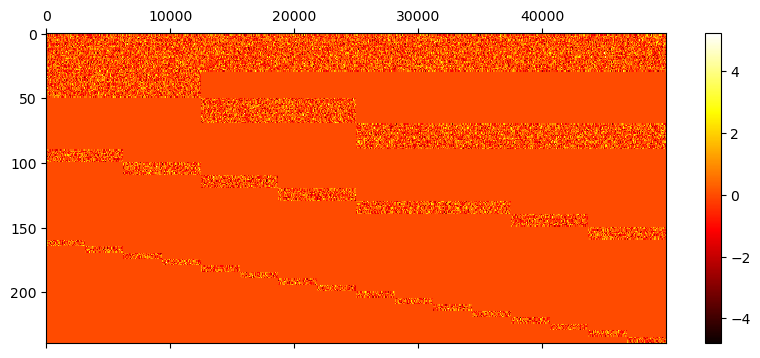

(50000, 240)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
tilde_B = mf.convert_compressed_to_sparse(true_mlr.B, true_mlr.hpart['rows'], true_mlr.ranks)
true_mlr.tilde_B = tilde_B
true_mlr.tilde_Ct = tilde_B.T.tocsc()
true_mlr.s = true_mlr.tilde_B.shape[1]

In [11]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [12]:
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

In [13]:
import timeit
v = np.random.randn(n, 1)

%timeit true_mlr.matvec(v)

3.92 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
# %timeit nb_mfm_matvec(true_compressed_F, true_D_noise[:, np.newaxis], F_hpart['pi'], F_hpart['pi_inv'], F_hpart["lk"], ranks, v)

10.2 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit mfm.mfm_matvec(true_compressed_F, true_D_noise, F_hpart, ranks, v)

4.78 ms ± 801 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
hat_x = mfm.fast_SMW_inverse(ranks, v, true_compressed_F, true_D_noise, F_hpart)
reldiff = np.linalg.norm(mfm.mfm_matvec(true_compressed_F, true_D_noise, F_hpart, ranks, hat_x) - v) / np.linalg.norm(v)
print(f"{reldiff=}")
# np.linalg.solve(true_mlr.matrix(), v) 

reldiff=7.299099914016941e-12


In [27]:
hat_x = mfm.iterative_refinement(ranks, v, true_compressed_F, true_D_noise, F_hpart, true_mlr, 
                                printing=True, eps=1e-14, max_iter=20)
reldiff = np.linalg.norm(mfm.mfm_matvec(true_compressed_F, true_D_noise, F_hpart, ranks, hat_x) - v) / np.linalg.norm(v)
print(f"{reldiff=}")

9.583273028867225e-12
2.0209159721003284e-12
1.0669781035586569e-12
9.418194405351682e-13
7.202079522466348e-13
7.575925992150701e-13
8.460512081338513e-13
8.506007612834154e-13
8.051344099471781e-13
9.071794406180409e-13
8.262114469546179e-13
8.773700708398391e-13
8.243575782353924e-13
7.685728708954273e-13
8.03273882784322e-13
8.402101896078262e-13
6.987836900135409e-13
8.204658187751645e-13
9.358035493565938e-13
1.175708107569078e-12
terminated with residual/v_norm=1.175708107569078e-12
reldiff=5.771974238853542e-12


In [ ]:
from numba import njit

@njit
def nb_mfm_matvec(F_compressed, D, pi, pi_inv, lks, ranks, x0):
    # return \Sigma x 
    # if len(x0.shape) == 1: x0 = x0.reshape(-1, 1)
    x = x0[pi]
    res = D * x
    for level in range(len(lks)):
        lk = lks[level]
        num_blocks = lk.size - 1 
        for block in range(num_blocks):
            r1, r2 = lk[block], lk[block+1]
            res[r1:r2] += F_compressed[r1:r2, ranks[:level].sum():ranks[:level+1].sum()] @ \
                (F_compressed[r1:r2, ranks[:level].sum():ranks[:level+1].sum()].T @ x[r1:r2])
    return res[pi_inv]